use opencv to select points on a provided 'map' (example uses a very simple one) and compute shortest distance path between the points.

In [203]:
# For original
import cv2 as cv
import math
import matplotlib.pyplot as plt
import numpy as np

In [204]:
def getPixelValues(px):
    # Get RGB values of a pixel as floats
    return [ float(px[0]), float(px[1]), float(px[2]) ]

def drawPath(img, path, pThick=2, colorToUse = (255,0,0)):
    # Given list of (x,y) values draw red lines btw. each coord to next then show path in img
    v = path[0]
    x0, y0 = v[0], v[1]
    for v in path:
        x, y = v[0], v[1]
        cv.line(img, (x, y), (x0, y0), colorToUse, pThick)
        x0, y0 = x, y

def getNotBlack():
    randomTuple = tuple(np.random.choice(np.arange(150)+20, size=3))  
    return [int(i) for i in randomTuple] #must set to int for opencv

In [205]:
class Vertex:
    """
    A class to represent a vertex
    
    attr:
        i (int): The x-coordinate of the vertex
        j (int): The y-coordinate of the vertex
        
    methods:
        reset(): Reset the vertex to be non-processed
    """
    def __init__(self, i, j):
        self.x = i
        self.y = j
        self.d = float('inf') # shortest path estimate
        self.processed = False  # Flag if final shortest path dist. has been computed
        self.idx_in_priority_queue = -1  
        self.pi = None  # Parent vertex in shortest path tree
        
    def reset(self):
        self.d = float('inf')
        self.processed = False
        self.idx_in_priority_queue = -1  
        self.pi = None  # Parent vertex in shortest path tree

In [206]:
class PriorityQueue:
    """
    A class to utilize Dijkstra's Algorithm efficiently
    
    methods:
        insert(v): Insert a vertex 'v' into the queue
        swap(i, j): Swap two elements in the priority queue.  Used in bubble up/down
        bubble_up(j): Bubble up an element 'j' until min-heap property restored
        bubble_down(j): Bubble down an element 'j' until min-heap property restored
        get_and_delete_min(): Find and delete min. weight vertex from heap, return deleted vertex
        is_empty(): Check if the heap is empty
        update_vertex_weight(v): Updates vertex weight 
    """
    def __init__(self):
        self.q = [None]  # Pad empty heap with 1 element
        
    def insert(self, v):
        n = len(self.q)
        self.q.append(v)
        v.idx_in_priority_queue = n
        self.bubble_up(n)
        
    def swap(self, i, j):
        tmp = self.q[i]
        self.q[i] = self.q[j]
        self.q[i].idx_in_priority_queue = i
        self.q[j] = tmp
        self.q[j].idx_in_priority_queue = j
        
    def bubble_up(self, j):
        assert j >= 1
        assert j < len(self.q)
        if j == 1:
            return
        val = self.q[j].d
        parent_idx = j // 2
        parent_val = self.q[parent_idx].d
        if val < parent_val:
            self.swap(j, parent_idx)
            self.bubble_up(parent_idx)
        return
    
    def bubble_down(self, j):
        n = len(self.q)
        left_child_idx = 2 * j
        right_child_idx = 2 * j + 1
        if left_child_idx >= n:
            return
        if right_child_idx >= n:
            child_idx = left_child_idx
            child_d = self.q[left_child_idx].d
        else:
            (child_d, child_idx) = min ( (self.q[left_child_idx].d, left_child_idx), 
                                         (self.q[right_child_idx].d, right_child_idx)
                                       )
        if self.q[j].d > child_d:
            self.swap(j, child_idx)
            self.bubble_down(child_idx)
        return 
    
    def get_and_delete_min(self):
        n = len(self.q)
        assert n > 1
        v = self.q[1]
        if n > 2: 
            self.q[1] = self.q[n-1]
            self.q[n-1].idx_in_priority_queue = 1
            del self.q[n-1]
            self.bubble_down(1)
        #self.check_invariant()
        return v
    
    def is_empty(self):
        return len(self.q) == 1
    
    def update_vertex_weight(self, v):
        j = v.idx_in_priority_queue
        n = len(self.q)
        assert j >= 0 and j < n
        self.bubble_down(j)
        self.bubble_up(j)

In [207]:
class DirectedGraphFromImage:
    """
    Class to create a directed graph from a supplied image
    
    args:
        img (FILL WITH cv.imread dtype): The cv-read image from which we create the directed graph
        
    methods:
        get_vertex_from_coords(i, j): If pixel (i, j) is there, return the corresponding vertex.  Else create and return.
        getEdgeWeight(u, v): Get squared euclidean distance between two neighboring pixels
        get_list_of_neighbors(vert): Get list of neighbors of vertex 'vert'
        
    """
    def __init__(self, img):
        self.img = img
        self.coords2vertex = {} # construct a dictionary that maps coordinates [(i,j)] to corresponding vertices in graph
    
        
    def get_vertex_from_coords(self, i, j):
        if (i,j) in self.coords2vertex: # is pixel (i,j) already there? 
            return self.coords2vertex[(i,j)] # if yes, just return the vertex corresponding
        v = Vertex(i, j)
        self.coords2vertex[(i,j)] = v
        return v
    
    ## Given (x,y) coordinates of two neighboring pixels, calculate the edge weight.
    # We take the squared euclidean distance between the pixel values and add 0.1
    def getEdgeWeight(self, u, v):
        img = self.img
        # get edge weight for edge between u, v
        i0,j0 = u.x, u.y
        i1,j1 = v.x, v.y
        height, width, _ = img.shape
        # First make sure that the edge is legit
        # Edges can only go from each pixel to neighboring pixel
        assert i0 >= 0 and j0 >= 0 and i0 < width and j0 < height # pixel position valid?
        assert i1 >= 0 and j1 >= 0 and i1 < width and j1 < height # pixel position valid?
        assert -1 <= i0 - i1 <= 1 # edge between node and neighbor?
        assert -1 <= j0 - j1 <= 1
        px1 = getPixelValues(img[j0,i0])
        px2 = getPixelValues(img[j1,i1])
        return 0.1 + (px1[0] - px2[0])**2 + (px1[1] - px2[1])**2 + (px1[2]- px2[2])**2

    def get_list_of_neighbors(self, vert):
        img = self.img
        i = vert.x
        j = vert.y
        height, width, _ = img.shape
        lst = []
        if i > 0:
             # Get the adjacent vertex directly to the WEST
            # What is the weight of the edge from pixel (i,j) to (i-1,j)
            v0 = self.get_vertex_from_coords(i-1, j)
            w0 = self.getEdgeWeight(vert, v0)
            # Append the adjacent vertex and its weight.
            lst.append((v0, w0))
        if j > 0:
            # Get the adjacent vertex directly to the SOUTH
            v1 = self.get_vertex_from_coords(i, j-1)
            w1 = self.getEdgeWeight(vert, v1)
            # Append the adjacent vertex and its weight.
            lst.append((v1, w1))    
        if i < width-1:
            # EAST
            v2 = self.get_vertex_from_coords(i+1, j)
            w2 = self.getEdgeWeight( vert, v2)
            lst.append((v2, w2))
        if j < height-1:
            # NORTH
            v3 = self.get_vertex_from_coords(i, j+1)
            w3 = self.getEdgeWeight(vert, v3)
            lst.append((v3, w3))
        return lst

In [208]:
def computeShortestPath(graph, source_coords, dest_coords):
    q = PriorityQueue()  # init empty prio queue
    source_vert = graph.get_vertex_from_coords(source_coords[0], source_coords[1])
    dest = graph.get_vertex_from_coords(dest_coords[0], dest_coords[1])
    source_vert.d = 0  # Set dist from source to source to 0
    q.insert(source_vert)  # Add source vertex to prio queue
    
    while q.is_empty() == False:
        u = q.get_and_delete_min()  
        u.processed = True
        
        if (u.x == dest.x) and (u.y == dest.y): # If 'u' has same coords as dest, then we're done
            shortest_dist = u.d
            break
        
        for edge in graph.get_list_of_neighbors(u):  # Go through each edge from u to v with weight w
            v = edge[0]
            w = edge[1]
            if (v.processed == False) and (v.d > u.d + w):
                v.d = u.d + w
                v.pi = u  # Set the parent of v to be u
                if v.idx_in_priority_queue == -1:  # If v is not in q, insert it.  Otherwise update the weights.
                    q.insert(v)
                else:
                    q.update_vertex_weight(v)
                    
    path_list = []  # Init path from source to dest coords
    path_list.append((dest.x, dest.y))  # append dest itself to the path list
    while dest.pi != None:  # While the current destination still has a parent
        path_list.append((dest.pi.x, dest.pi.y))
        dest = dest.pi  # update dest to latest point
    return((path_list[::-1], shortest_dist))  # -1 to reverse order since we went from dest to source.

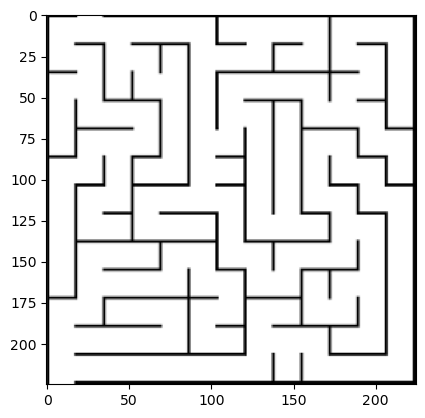

In [209]:
img = cv.imread(r'testMaps/maze0.png')
plt.imshow(img)

In [210]:
graph = DirectedGraphFromImage(img)

In [211]:
p, dist = computeShortestPath(graph, (5,220), (5,5))

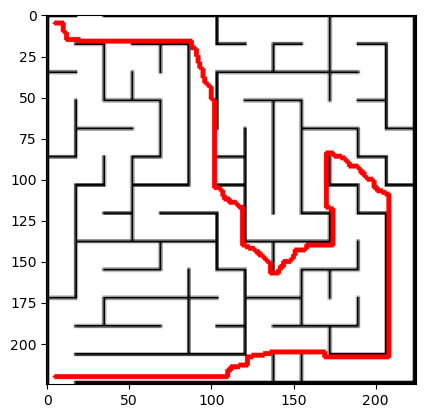

In [212]:
drawPath(img, p, 2)
plt.imshow(img)
plt.show()


In [213]:
def setPOI(imgPath, showPOI=False):
    """
    Function for setting points of interest on a given image.  
    
    Used in getOrderedMap. By default hides the POI map.
    Once ran, opens a window where POIs are selected with LMB.  RMB closes the map and finalizes the POIs.
    Returns the list of POIs (bucket), the path to the image (imgPath), and the colors used (colorsUsed).
    
    args:
        imgPath (str): String path to image to use - read in as cv.imread('filepath')
        showPOI (bool): Boolean if we want to display the POI map or not.  Default to not show map.
    """
    img = cv.imread(imgPath)
    graph = DirectedGraphFromImage(img)
    bucket = []  # Holds the set points' coordinates
    i = 0  # Simple iterator for coloring
    colorsUsed = []
    
    def mouseClick(event, x, y, flags, param): #Inner function for definine what to do on mouse click(s)
        nonlocal i
        if event == cv.EVENT_LBUTTONDOWN:
            # print(i)
            # if i % 2 == 0:
            #     colorsUsed.append(getNotBlack())
            # else:
            #     colorsUsed.append(colorsUsed[i-1])
            colorsUsed.append(getNotBlack())
            font = cv.FONT_HERSHEY_SIMPLEX
            cv.putText(img, f"{i}", (x,y), font, 0.5, colorsUsed[i], 2)
            cv.circle(img, (x,y), 2, colorsUsed[i], -1)  # add circle centered at LMB click
            cv.imshow('image', img)
            bucket.append((x,y))
            i+=1
        if event == cv.EVENT_RBUTTONDOWN:
            cv.destroyAllWindows()
        
        
    cv.imshow('image', img)
    cv.setMouseCallback('image', mouseClick)
    cv.waitKey(0)
    if showPOI == True:
        plt.imshow(img)
    return(bucket, imgPath, colorsUsed)

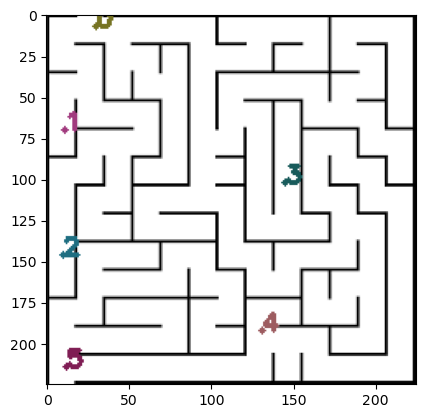

In [215]:
poiList, imgPath, colorsUsed = setPOI(r'testMaps/maze0.png', showPOI=True)

In [216]:
def getOrderedMap(POI, returnVals=False):
    """
    Function for mapping between POIs in order of selection.  Made to use setPOI().  Returns subplots showing shortest path(s) between POIs.
    
    args:
        POI (func): setPOI(imgPath) as defined above.  Use showPOI=True to show POI map.
        returnVals (bool): If true, returns the np.array for the images used, the list of POIs used, the image path, and the colors used.
    """
    allImgs = []
    poiList = POI[0]
    imgPath = POI[1]
    colorsUsed = POI[2]
    for i in range(len(poiList)-1):
        img = cv.imread(imgPath)  # Refresh every time so we don't path around drawn lines
        allImgs.append(img) 
        graph = DirectedGraphFromImage(img)
        p, dist = computeShortestPath(graph, poiList[i], poiList[i+1])
        drawPath(img, p, 2, colorToUse=colorsUsed[i])
        
    fig, axs = plt.subplots((len(allImgs)//3+1), 3)  # Always have 3 columns, num rows depends on num POIs
    for i, ax in enumerate(fig.axes):
        try:
            ax.set_title(f"Path {i+1}")
            ax.imshow(allImgs[i])
        except IndexError:
            ax.axis('off')  # When we get to a point where there aren't any more plots
    if returnVals:
        return(allImgs, poiList, imgPath, colorsUsed)

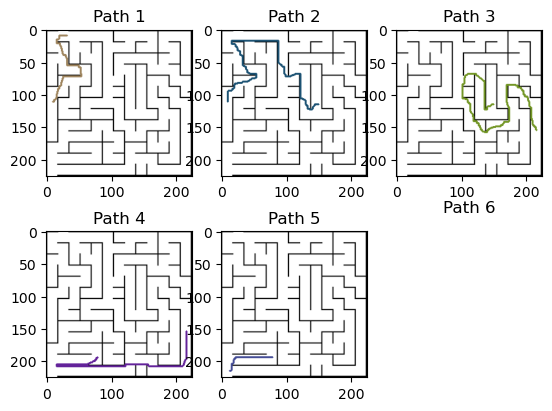

In [217]:
getOrderedMap(setPOI(r'testMaps/maze0.png', showPOI=False))
# POI map not really required, would usually use default showPOI=False